<a href="https://colab.research.google.com/github/Processamento-de-video-UFABC-2021-2/Processamento-de-video-UFABC-2021-2.github.io/blob/main/colab-notebooks/relatorio_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math as Math
from google.colab.patches import cv2_imshow # cv2_imshow
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


A função abaixo realiza a conversão do objeto javascript para o modelo utilizado pelo OpenCV



In [ ]:
# Função que realiza a conversão do objeto Javascript, identificado pela função "eval_js", e transforma para o padrão lido pelo OpenCV
# -------------- Código retirado do vídeo: "How to Use Webcam In Google Colab for Images and Video (FACE DETECTION)" -------------- #
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv.imdecode(jpg_as_np, flags=1)

  return img
  # -------------------------------------------------------------------------------------------------------------------------------- #

O código abaixo realiza uma requisição HTTP nos dados providos pela documentação do OpenCV, o qual já possui o classificador "treinado" para detecção de face e dos olhos, e redireciona o `output` para um arquivo (No caso, redirecionado para o diretório de nossa escolha)

In [ ]:
!curl -s -o /content/drive/My\ Drive/processamento-de-video/face_cascade.xml \
    https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml \

!curl -s -o /content/drive/My\ Drive/processamento-de-video/eyes_cascade.xml \
    https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye_tree_eyeglasses.xml \

A biblioteca OpenCV possui a função `CascadeClassifier()`, a qual é capaz de ler um modelo pré-treinado para criar um classificador. No nosso caso, utilizaremos os modelos adquiridos pelo código acima.



In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv.CascadeClassifier('/content/drive/My Drive/processamento-de-video/face_cascade.xml')
eyes_cascade = cv.CascadeClassifier('/content/drive/My Drive/processamento-de-video/eyes_cascade.xml')


Como solução para acesso à webcam via Collab, parte do código abaixo foi retirado da aba "Snippets de Código" da própria ferramenta. Assim, é executado um código em JavaScript que acessa o elemento HTML da câmera, presente no navegador, e obtém uma imagem. 

Após a imagem ser obtida, é realizado seu processamento para detecção da face e dos olhos, utilizando o classificador "Cascade", criado acima nas variáveis "face_cascade" e "eyes_cascade"

In [ ]:
# ------------------- Código retirado do Snippets de Códigos do Google Collab ------------------- #
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
# ----------------------------------------------------------------------------------------------- #

  # Dados da imagem
  data = eval_js('takePhoto({})'.format(quality))
  # Chamada da função responsável por converter de Javascript para Python/Formato OpenCV
  img = js_to_image(data) 
  # Transforma a imagem para "grayscale"
  gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
  # Mostra as dimensões da imagem no log de execução
  print(gray.shape)
  # Executa a função "detecMultiScale", a qual retorna uma lista de "retângulos" dos objetos detectados, que no caso seria a face
  faces = face_cascade.detectMultiScale(gray)
  # Para cada face detectada, o loop "desenha" um retângulo, o qual será visto no output 
  for (x,y,w,h) in faces:
    # Desenha os retângulos na imagem
    img = cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    faceROI = gray[y:y+h,x:x+w]
    # Executa a função "detecMultiScale", a qual retorna uma lista de "retângulos" dos objetos detectados, que no caso seriam os olhos
    eyes = eyes_cascade.detectMultiScale(faceROI)
    # Para os olhos detectados, o loop "desenha" um círculo, o qual será visto no output 
    for (x2,y2,w2,h2) in eyes:
      eye_center = (x + x2 + w2//2, y + y2 + h2//2)
      radius = int(round((w2 + h2)*0.25))
      # Desenha os círculos na imagem
      img = cv.circle(img, eye_center, radius, (255, 0, 0 ), 4)
  
  # Salva a imagem
  cv.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

(480, 640)
Saved to photo.jpg


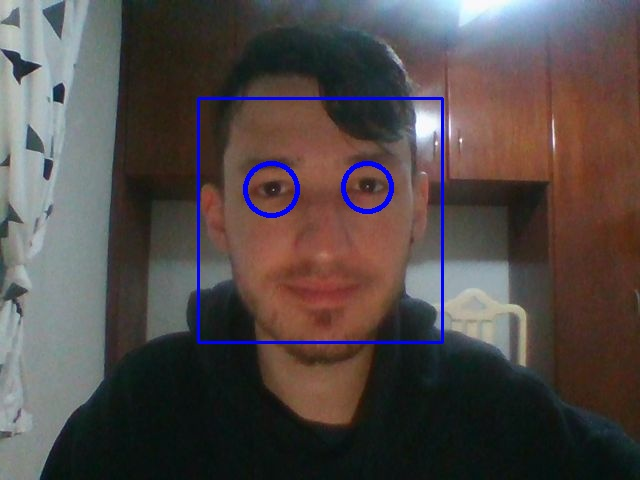

In [ ]:
# ------------------- Código retirado do Snippets de Códigos do Google Collab ------------------- #
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))